# Generative Adversarial Network Tutorial 00

In particle physics, Generative Adversarial Networks hold a lot of promise for studying data/MC differences.  In principle, the physics tools used for simulation of particle interaction data are quite good, but they are never perfect.  Additionally, they are always imperfect in difficult to model ways.  Many experiments spend a lot of time studying the differences between the output of their simulation and their real detector data, and a deep network that can learn these differences is really useful for making progress.

In this tutorial, I'll cover some basics of generative adversarial networks with very simple feed-forward neural networks (not even convolutional) as a demonstration of the basic techniques of GANs.  You can read the original paper on GANs here: https://arxiv.org/abs/1406.2661.  The basic idea is you train two networks to compete with each other.  The first (called the discriminator) makes a decision on whether or not the images it's looking at are real or fake.  The second (called the generator) tries to generate fake images from random noise to fool the discriminator.

In the years since the original paper came out, GANs have grown increasinly more sophisticated and impressive, especially with the advent of the Deep Convolutional Generative Adversarial Network (DCGAN, original paper: https://arxiv.org/abs/1511.06434).  For this tutorial, we're going to eschew all of the recent advances to make a GAN that can generate artificial digits based on the mnist data set.  By stripping the networks down to their basics, it's easier to focus on the core aspects of the loss function and outputs, and to avoid the complications of training on GPUs, etc.

## MNIST data set

The mnist data set is one of the most famous collections of labeled images that exists.  You can read all about it at the original website (http://yann.lecun.com/exdb/mnist/), but it has a few nice advantages that make it ideal for learning:
 * It's open, and has convient wrappers in many languages (we'll use tensorflows soon)
 * It's a large data set (60k training images) but each image is small (28x28)
 * The data has been preprocessed to center images of digits and make them easier to use
 
Basically, you can focus on the fundamentals with this data set, which is why we'll use it here.  Some examples of loading it with tensorflow (more here: https://www.tensorflow.org/get_started/mnist/beginners)

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


With tensorflow, you can specify which device to use.  The next cell will tell you what's available, and you can select from there.  By default, I select "/gpu:0" but you can change this below

In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/gpu:0"

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 562091587952366681
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11946606592
locality {
  bus_id: 1
}
incarnation: 6214697808030998256
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0"
]


In [3]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_images, mnist_labels = mnist.train.next_batch(batch_size=5)

Here, we've loaded the mnist data from the tensorflow helper class, and asked for the next batch of images and labels.  Let's view those to see what the data looks like before delving into the network:

In [5]:
print "mnist_images.shape: {}".format(mnist_images.shape)
print "mnist_labels.shape: {}".format(mnist_labels.shape)

mnist_images.shape: (5, 784)
mnist_labels.shape: (5,)


As expected, variables are arrays with the outermost dimension equal to 5.  The images, though, comes unpacked as a 1D array per image instead of a 2D array.  We can reshape this to what we're more familar with, since we know mnist images are 28x28:

In [6]:
mnist_images = numpy.reshape(mnist_images, (-1, 28, 28)) # -1 can be used as a placeholder for batch size here

In [7]:
print "mnist_images.shape: {}".format(mnist_images.shape)


mnist_images.shape: (5, 28, 28)


Matplotlib gives a good interface for viewing these images in a notebook (or even in general, in python):

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

This image is labeled as 9


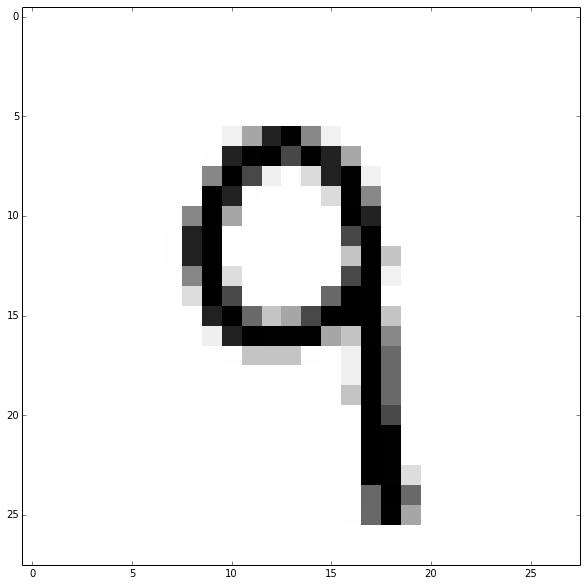

In [9]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(mnist_images[index], cmap="Greys", interpolation="none")
print "This image is labeled as {}".format(mnist_labels[index])
plt.show()

Drawn like this, you can see each individual pixel clearly.  It's not a high resolution image, but you can clearly tell what the digit is!

## Building a model for a GAN

We'll start to put together a network for the GAN, first by defining some useful constants that we'll need to call on multiple times:

In [10]:
BASE_LEARNING_RATE = 0.000001
BATCH_SIZE=64 # Keep this even
N_HIDDEN_NEURONS=1024
LOGDIR="./mnist_gan_logs/lr_{}_neurons_{}".format(BASE_LEARNING_RATE, N_HIDDEN_NEURONS)
RESTORE=True

Additionally, let's make sure we have the same graph by defining it:

In [11]:
tf.reset_default_graph()
g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both real images and random noise, so make a placeholder for both.  Additionally, based on this blog post (http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/) I add random gaussian noise to the real and fake images as they are fed to the discriminator to help stabalize training.

In [12]:
with tf.device(default_device):
    with g.as_default():
        # Input noise to the generator:
        noise_tensor = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 10*10], name="noise")
        fake_input   = tf.reshape(noise_tensor, (tf.shape(noise_tensor)[0], 10,10, 1))

        # Placeholder for the discriminator input:
        real_flat  = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 784], name='x')
        # label_tensor = tf.placeholder(tf.float32, [BATCH_SIZE, 1], name='labels')
        real_images  = tf.reshape(real_flat, (tf.shape(real_flat)[0], 28, 28, 1))

        # We augment the input to the discriminator with gaussian noise
        # This makes it harder for the discriminator to do it's job, preventing
        # it from always "winning" the GAN min/max contest
        real_noise = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 28, 28, 1], name="real_noise")
        fake_noise = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 28, 28, 1], name="fake_noise")

        real_images = real_noise + real_images


Notice how the input tensors (noise_tensor, real_images) are shaped in the 'flattened' way: (N/2, 100) for noise, (N/2, 784) for real images.  This lets me input the mnist images directly to tensorflow, as well as the noise.  They are then reshaped to be like tensorflow images (Batch, H, W, Filters).

### Image Discriminator:

Make a function to build the discriminator, using fully connected networks.  Note that a convolutional layer with the stride equal to the image size *is* a fully connected layer.

In [13]:
def build_discriminator(input_tensor, reuse,reg=0.1):
    # Use scoping to keep the variables nicely organized in the graph.
    # Scoping is good practice always, but it's *essential* here as we'll see later on
    with tf.variable_scope("mnist_discriminator", reuse=reuse):
        x = tf.layers.conv2d(input_tensor,
                             filters=128, #Connecting to 128 output neurons, each it's own filter
                             kernel_size=[28,28], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_1")
        # Apply a non linearity:
        x = tf.nn.relu(x)
        # That maps to a hidden layer, shape is (B, 1, 1, 128), let's now map to a single output
        x = tf.layers.conv2d(x,
                             filters=1,         #Connecting to 1 output neuron
                             kernel_size=[1,1], 
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_2")
        
        # Since we want to predict "real" or "fake", an output of 0 or 1 is desired.  sigmoid is perfect for this:
        x = tf.nn.sigmoid(x, name="discriminator_sigmoid")
        #Reshape this to bring it down to just one output per image:
        x = tf.reshape(x, (x.get_shape().as_list()[0],))
        return x

In [14]:
with tf.device(default_device):
    with g.as_default():
        real_image_logits = build_discriminator(real_images, reuse=False,reg=0.2)

Now we can define a function to generate random images from noise:

In [15]:
def build_generator(input_tensor, reg=0.2):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_generator"):
        # Input is Bx10x10x1, let's use two hidden layers this time to upsample to 28x28:
        x = tf.layers.conv2d(input_tensor,
                             filters=N_HIDDEN_NEURONS,
                             kernel_size=[10,10], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_1")
        
        # Apply nonlinearity, this time using a 'leaky relu':
        x = tf.maximum(x, 0.1*x)
        
        
        # Another fully connected layer, no change to resolution yet:
        x = tf.layers.conv2d(x,
                             filters=N_HIDDEN_NEURONS,
                             kernel_size=[1,1], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_2")
        
        # Apply nonlinearity, this time using a 'leaky relu':
        x = tf.maximum(x, 0.1*x)
        
        
        
        # Final layer, step up to "full" resolution and then reshape the tensor:
        x = tf.layers.conv2d(x,
                             filters=784, #784 is a 28x28 image
                             kernel_size=[1,1], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_3")
        
        # Reshape to match mnist images:
        x = tf.reshape(x, (-1, 28, 28, 1))
        
        # The final non linearity applied here is to map the images onto the [-1,1] range.
        x = tf.nn.tanh(x, name="generator_tanh")
        return x

In [16]:
with tf.device(default_device):
    with g.as_default():
        fake_images = build_generator(fake_input) 

We also need to be able to run the discriminator on the fake images, so set that up too.  Since it trains on both real and fake images, set reuse=True here:

In [17]:
with tf.device(default_device):
    with g.as_default():
        fake_image_logits = build_discriminator(fake_images, reuse=True, reg=0.2)

### Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the generator and discriminator seperately:

In [18]:
with tf.device(default_device):
    # Build the loss functions:
    with g.as_default():
        with tf.name_scope("cross_entropy") as scope:

            #Discriminator loss on real images (classify as 1):
            d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_image_logits,
                labels = tf.ones_like(real_image_logits)))
            #Discriminator loss on fake images (classify as 0):
            d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_logits,
                labels = tf.zeros_like(fake_image_logits)))

            # Total discriminator loss is the sum:
            d_loss_total = d_loss_real + d_loss_fake

            # This is the adverserial step: g_loss tries to optimize fake_logits to one,
            # While d_loss_fake tries to optimize fake_logits to zero.
            g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_logits,
                labels = tf.ones_like(fake_image_logits)))

            # This code is useful if you'll use tensorboard to monitor training:
            d_loss_summary = tf.summary.scalar("Discriminator_Real_Loss", d_loss_real)
            d_loss_summary = tf.summary.scalar("Discriminator_Fake_Loss", d_loss_fake)
            d_loss_summary = tf.summary.scalar("Discriminator_Total_Loss", d_loss_total)
            d_loss_summary = tf.summary.scalar("Generator_Loss", g_loss)


It's also useful to compute accuracy, just to see how the training is going:

In [19]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("accuracy") as scope:
            # Compute the discriminator accuracy on real data, fake data, and total:
            accuracy_real  = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_image_logits), 
                                                             tf.ones_like(real_image_logits)), 
                                                    tf.float32))
            accuracy_fake  = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_image_logits), 
                                                             tf.zeros_like(fake_image_logits)), 
                                                    tf.float32))

            total_accuracy = 0.5*(accuracy_fake +  accuracy_real)

            # Again, useful for tensorboard:
            acc_real_summary = tf.summary.scalar("Real_Accuracy", accuracy_real)
            acc_real_summary = tf.summary.scalar("Fake_Accuracy", accuracy_fake)
            acc_real_summary = tf.summary.scalar("Total_Accuracy", total_accuracy)

### Independant Optimizers

To allow the generator and discriminator to compete and update seperately, we use two distinct optimizers.  This step is why it was essential earlier to have the scopes different for the generator and optimizer: we can select all variables in each scope to go to their own optimizer.  So, even though the generator loss calculation runs the discriminator, the update step for the generator **only** affects the variables inside the generator

In [20]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("training") as scope:
            # Global steps are useful for restoring training:
            global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

            # Make sure the optimizers are only operating on their own variables:

            all_variables      = tf.trainable_variables()
            discriminator_vars = [v for v in all_variables if v.name.startswith('mnist_discriminator/')]
            generator_vars     = [v for v in all_variables if v.name.startswith('mnist_generator/')]


            discriminator_optimizer = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                d_loss_total, global_step=global_step, var_list=discriminator_vars)
            generator_optimizer     = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                g_loss, global_step=global_step, var_list=generator_vars)


### Image snapshots

It's useful to snapshot images into tensorboard to see how things are going, as well:

In [21]:
with tf.device(default_device):
    with g.as_default():
        tf.summary.image('fake_images', fake_images, max_outputs=4)
        tf.summary.image('real_images', real_images, max_outputs=4)


## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [22]:
with tf.device(default_device):
    with g.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)

Set up a session for training using an interactive session:

In [23]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        if not RESTORE:
            sess.run(tf.global_variables_initializer())
            train_writer.add_graph(sess.graph)
            saver = tf.train.Saver()
        else: 
            latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
            print "Restoring model from {}".format(latest_checkpoint)
            saver = tf.train.Saver()
            saver.restore(sess, latest_checkpoint)



        print "Begin training ..."
        # Run training loop
        for i in xrange(50000):
            step = sess.run(global_step)

            # Receive data (this will hang if IO thread is still running = this
            # will wait for thread to finish & receive data)

            sigma = max(0.5*(40000. - step) / (40000), 0.01)

            # Update the generator:
            # Prepare the input to the networks:
            fake_input = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))
            real_data, label = mnist.train.next_batch(int(BATCH_SIZE*0.5))
            real_data = 2*(real_data - 0.5)

            real_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),28,28,1))
            fake_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),28,28,1))


            [  acc_fake, _ ] = sess.run(
                [accuracy_fake, 
                 generator_optimizer], 
                feed_dict = {noise_tensor: fake_input,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})

            # Update the discriminator:
            # Prepare the input to the networks:
            fake = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))
            real_data, label = mnist.train.next_batch(int(BATCH_SIZE*0.5))
            real_data = 2*(real_data - 0.5)
            [generated_mnist, _] = sess.run([fake_images, 
                                            discriminator_optimizer], 
                                            feed_dict = {noise_tensor : fake_input,
                                                         real_flat : real_data,
                                                         real_noise: real_noise_addition,
                                                         fake_noise: fake_noise_addition})




            [summary, g_l, acc_fake, d_l_r, acc] = sess.run(
                [merged_summary, g_loss, accuracy_fake,
                 d_loss_real, total_accuracy],
                feed_dict = {noise_tensor : fake,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})


            train_writer.add_summary(summary, step)


            if step != 0 and step % 500 == 0:
                saver.save(
                    sess,
                    LOGDIR+"/checkpoints/save",
                    global_step=step)


            # train_writer.add_summary(summary, i)
            # sys.stdout.write('Training in progress @ step %d\n' % (step))
            if step % 50 == 0:
                print 'Training in progress @ global_step %d, g_loss %g, d_loss %g accuracy %g' % (step, g_l, d_l_r, acc)


Restoring model from ./mnist_gan_logs/lr_1e-06_neurons_1024/checkpoints/save-99500
INFO:tensorflow:Restoring parameters from ./mnist_gan_logs/lr_1e-06_neurons_1024/checkpoints/save-99500
Begin training ...
Training in progress @ global_step 99550, g_loss 0.515897, d_loss 0.439522 accuracy 0.90625
Training in progress @ global_step 99600, g_loss 0.514417, d_loss 0.440955 accuracy 0.921875
Training in progress @ global_step 99650, g_loss 0.505968, d_loss 0.438132 accuracy 0.9375
Training in progress @ global_step 99700, g_loss 0.512955, d_loss 0.445203 accuracy 0.921875
Training in progress @ global_step 99750, g_loss 0.512432, d_loss 0.45219 accuracy 0.921875
Training in progress @ global_step 99800, g_loss 0.511584, d_loss 0.447963 accuracy 0.890625
Training in progress @ global_step 99850, g_loss 0.512335, d_loss 0.448797 accuracy 0.828125
Training in progress @ global_step 99900, g_loss 0.516602, d_loss 0.448242 accuracy 0.921875
Training in progress @ global_step 99950, g_loss 0.513

Training in progress @ global_step 103900, g_loss 0.522268, d_loss 0.456855 accuracy 0.890625
Training in progress @ global_step 103950, g_loss 0.517163, d_loss 0.452988 accuracy 0.875
Training in progress @ global_step 104000, g_loss 0.522549, d_loss 0.463116 accuracy 0.78125
Training in progress @ global_step 104050, g_loss 0.52256, d_loss 0.461217 accuracy 0.796875
Training in progress @ global_step 104100, g_loss 0.520439, d_loss 0.454556 accuracy 0.828125
Training in progress @ global_step 104150, g_loss 0.518956, d_loss 0.454203 accuracy 0.890625
Training in progress @ global_step 104200, g_loss 0.524235, d_loss 0.454659 accuracy 0.90625
Training in progress @ global_step 104250, g_loss 0.516084, d_loss 0.460315 accuracy 0.8125
Training in progress @ global_step 104300, g_loss 0.517899, d_loss 0.458605 accuracy 0.796875
Training in progress @ global_step 104350, g_loss 0.523921, d_loss 0.465676 accuracy 0.78125
Training in progress @ global_step 104400, g_loss 0.523182, d_loss 0.

Training in progress @ global_step 108350, g_loss 0.522351, d_loss 0.454131 accuracy 0.84375
Training in progress @ global_step 108400, g_loss 0.522121, d_loss 0.466444 accuracy 0.8125
Training in progress @ global_step 108450, g_loss 0.518233, d_loss 0.472175 accuracy 0.734375
Training in progress @ global_step 108500, g_loss 0.522523, d_loss 0.458004 accuracy 0.8125
Training in progress @ global_step 108550, g_loss 0.520879, d_loss 0.472909 accuracy 0.75
Training in progress @ global_step 108600, g_loss 0.521493, d_loss 0.460195 accuracy 0.796875
Training in progress @ global_step 108650, g_loss 0.521364, d_loss 0.453476 accuracy 0.828125
Training in progress @ global_step 108700, g_loss 0.51995, d_loss 0.45934 accuracy 0.828125
Training in progress @ global_step 108750, g_loss 0.521945, d_loss 0.470604 accuracy 0.734375
Training in progress @ global_step 108800, g_loss 0.523455, d_loss 0.474288 accuracy 0.703125
Training in progress @ global_step 108850, g_loss 0.516539, d_loss 0.46

Training in progress @ global_step 112800, g_loss 0.514921, d_loss 0.45678 accuracy 0.765625
Training in progress @ global_step 112850, g_loss 0.514402, d_loss 0.469495 accuracy 0.71875
Training in progress @ global_step 112900, g_loss 0.513415, d_loss 0.467311 accuracy 0.765625
Training in progress @ global_step 112950, g_loss 0.512437, d_loss 0.465841 accuracy 0.78125
Training in progress @ global_step 113000, g_loss 0.512096, d_loss 0.471102 accuracy 0.6875
Training in progress @ global_step 113050, g_loss 0.515082, d_loss 0.469061 accuracy 0.765625
Training in progress @ global_step 113100, g_loss 0.512084, d_loss 0.460739 accuracy 0.796875
Training in progress @ global_step 113150, g_loss 0.512868, d_loss 0.469599 accuracy 0.765625
Training in progress @ global_step 113200, g_loss 0.513269, d_loss 0.467535 accuracy 0.734375
Training in progress @ global_step 113250, g_loss 0.519415, d_loss 0.46374 accuracy 0.84375
Training in progress @ global_step 113300, g_loss 0.514497, d_loss 

Training in progress @ global_step 117250, g_loss 0.513764, d_loss 0.460283 accuracy 0.765625
Training in progress @ global_step 117300, g_loss 0.509405, d_loss 0.46014 accuracy 0.765625
Training in progress @ global_step 117350, g_loss 0.506008, d_loss 0.461304 accuracy 0.8125
Training in progress @ global_step 117400, g_loss 0.512385, d_loss 0.462342 accuracy 0.734375
Training in progress @ global_step 117450, g_loss 0.515466, d_loss 0.463512 accuracy 0.71875
Training in progress @ global_step 117500, g_loss 0.510633, d_loss 0.457992 accuracy 0.765625
Training in progress @ global_step 117550, g_loss 0.51236, d_loss 0.467476 accuracy 0.71875
Training in progress @ global_step 117600, g_loss 0.509508, d_loss 0.468005 accuracy 0.6875
Training in progress @ global_step 117650, g_loss 0.499952, d_loss 0.471005 accuracy 0.59375
Training in progress @ global_step 117700, g_loss 0.511487, d_loss 0.478206 accuracy 0.65625
Training in progress @ global_step 117750, g_loss 0.511455, d_loss 0.4

Training in progress @ global_step 121700, g_loss 0.515729, d_loss 0.472063 accuracy 0.796875
Training in progress @ global_step 121750, g_loss 0.513097, d_loss 0.469436 accuracy 0.765625
Training in progress @ global_step 121800, g_loss 0.515552, d_loss 0.472388 accuracy 0.71875
Training in progress @ global_step 121850, g_loss 0.518465, d_loss 0.469728 accuracy 0.75
Training in progress @ global_step 121900, g_loss 0.517624, d_loss 0.469544 accuracy 0.75
Training in progress @ global_step 121950, g_loss 0.517951, d_loss 0.475701 accuracy 0.71875
Training in progress @ global_step 122000, g_loss 0.520539, d_loss 0.472656 accuracy 0.703125
Training in progress @ global_step 122050, g_loss 0.520768, d_loss 0.482119 accuracy 0.640625
Training in progress @ global_step 122100, g_loss 0.52016, d_loss 0.47592 accuracy 0.6875
Training in progress @ global_step 122150, g_loss 0.523064, d_loss 0.475905 accuracy 0.71875
Training in progress @ global_step 122200, g_loss 0.519174, d_loss 0.484162

Training in progress @ global_step 126150, g_loss 0.527874, d_loss 0.488417 accuracy 0.65625
Training in progress @ global_step 126200, g_loss 0.529414, d_loss 0.486151 accuracy 0.640625
Training in progress @ global_step 126250, g_loss 0.526755, d_loss 0.479586 accuracy 0.6875
Training in progress @ global_step 126300, g_loss 0.527759, d_loss 0.491512 accuracy 0.609375
Training in progress @ global_step 126350, g_loss 0.531702, d_loss 0.478678 accuracy 0.6875
Training in progress @ global_step 126400, g_loss 0.529822, d_loss 0.488462 accuracy 0.640625
Training in progress @ global_step 126450, g_loss 0.529807, d_loss 0.486728 accuracy 0.609375
Training in progress @ global_step 126500, g_loss 0.529037, d_loss 0.490519 accuracy 0.609375
Training in progress @ global_step 126550, g_loss 0.530108, d_loss 0.489955 accuracy 0.578125
Training in progress @ global_step 126600, g_loss 0.526802, d_loss 0.487818 accuracy 0.59375
Training in progress @ global_step 126650, g_loss 0.52929, d_loss 

Training in progress @ global_step 130600, g_loss 0.525073, d_loss 0.481471 accuracy 0.671875
Training in progress @ global_step 130650, g_loss 0.524978, d_loss 0.48606 accuracy 0.671875
Training in progress @ global_step 130700, g_loss 0.525715, d_loss 0.481084 accuracy 0.65625
Training in progress @ global_step 130750, g_loss 0.527309, d_loss 0.482065 accuracy 0.65625
Training in progress @ global_step 130800, g_loss 0.527348, d_loss 0.478231 accuracy 0.65625
Training in progress @ global_step 130850, g_loss 0.525942, d_loss 0.484242 accuracy 0.609375
Training in progress @ global_step 130900, g_loss 0.525963, d_loss 0.486262 accuracy 0.625
Training in progress @ global_step 130950, g_loss 0.52909, d_loss 0.471177 accuracy 0.703125
Training in progress @ global_step 131000, g_loss 0.527974, d_loss 0.479404 accuracy 0.703125
Training in progress @ global_step 131050, g_loss 0.526983, d_loss 0.477742 accuracy 0.65625
Training in progress @ global_step 131100, g_loss 0.526658, d_loss 0.

Training in progress @ global_step 135050, g_loss 0.517753, d_loss 0.463834 accuracy 0.8125
Training in progress @ global_step 135100, g_loss 0.521081, d_loss 0.473429 accuracy 0.703125
Training in progress @ global_step 135150, g_loss 0.522817, d_loss 0.475245 accuracy 0.671875
Training in progress @ global_step 135200, g_loss 0.521394, d_loss 0.467138 accuracy 0.78125
Training in progress @ global_step 135250, g_loss 0.519764, d_loss 0.469175 accuracy 0.765625
Training in progress @ global_step 135300, g_loss 0.51957, d_loss 0.46599 accuracy 0.828125
Training in progress @ global_step 135350, g_loss 0.517043, d_loss 0.468114 accuracy 0.8125
Training in progress @ global_step 135400, g_loss 0.521464, d_loss 0.471414 accuracy 0.796875
Training in progress @ global_step 135450, g_loss 0.518702, d_loss 0.468831 accuracy 0.75
Training in progress @ global_step 135500, g_loss 0.519794, d_loss 0.465839 accuracy 0.828125
Training in progress @ global_step 135550, g_loss 0.516832, d_loss 0.46

Training in progress @ global_step 139500, g_loss 0.519717, d_loss 0.45927 accuracy 0.828125
Training in progress @ global_step 139550, g_loss 0.51714, d_loss 0.465938 accuracy 0.78125
Training in progress @ global_step 139600, g_loss 0.515168, d_loss 0.462827 accuracy 0.8125
Training in progress @ global_step 139650, g_loss 0.515418, d_loss 0.466709 accuracy 0.765625
Training in progress @ global_step 139700, g_loss 0.516435, d_loss 0.460313 accuracy 0.8125
Training in progress @ global_step 139750, g_loss 0.516568, d_loss 0.472064 accuracy 0.765625
Training in progress @ global_step 139800, g_loss 0.517492, d_loss 0.459184 accuracy 0.84375
Training in progress @ global_step 139850, g_loss 0.518264, d_loss 0.461224 accuracy 0.796875
Training in progress @ global_step 139900, g_loss 0.516123, d_loss 0.465329 accuracy 0.75
Training in progress @ global_step 139950, g_loss 0.513444, d_loss 0.464551 accuracy 0.78125
Training in progress @ global_step 140000, g_loss 0.51921, d_loss 0.46755

Training in progress @ global_step 143950, g_loss 0.511067, d_loss 0.457595 accuracy 0.90625
Training in progress @ global_step 144000, g_loss 0.512273, d_loss 0.455788 accuracy 0.890625
Training in progress @ global_step 144050, g_loss 0.509852, d_loss 0.455736 accuracy 0.953125
Training in progress @ global_step 144100, g_loss 0.510741, d_loss 0.458333 accuracy 0.9375
Training in progress @ global_step 144150, g_loss 0.511673, d_loss 0.452488 accuracy 0.9375
Training in progress @ global_step 144200, g_loss 0.516797, d_loss 0.448355 accuracy 0.96875
Training in progress @ global_step 144250, g_loss 0.510761, d_loss 0.451663 accuracy 0.9375
Training in progress @ global_step 144300, g_loss 0.514883, d_loss 0.454868 accuracy 0.890625
Training in progress @ global_step 144350, g_loss 0.509662, d_loss 0.453382 accuracy 0.890625
Training in progress @ global_step 144400, g_loss 0.513954, d_loss 0.458809 accuracy 0.921875
Training in progress @ global_step 144450, g_loss 0.509425, d_loss 0

Training in progress @ global_step 148400, g_loss 0.53022, d_loss 0.476851 accuracy 0.703125
Training in progress @ global_step 148450, g_loss 0.52976, d_loss 0.479583 accuracy 0.6875
Training in progress @ global_step 148500, g_loss 0.534028, d_loss 0.464875 accuracy 0.796875
Training in progress @ global_step 148550, g_loss 0.529691, d_loss 0.473054 accuracy 0.75
Training in progress @ global_step 148600, g_loss 0.526728, d_loss 0.466835 accuracy 0.78125
Training in progress @ global_step 148650, g_loss 0.529853, d_loss 0.472628 accuracy 0.796875
Training in progress @ global_step 148700, g_loss 0.530504, d_loss 0.477015 accuracy 0.703125
Training in progress @ global_step 148750, g_loss 0.530895, d_loss 0.481364 accuracy 0.671875
Training in progress @ global_step 148800, g_loss 0.531089, d_loss 0.477703 accuracy 0.65625
Training in progress @ global_step 148850, g_loss 0.53104, d_loss 0.481454 accuracy 0.65625
Training in progress @ global_step 148900, g_loss 0.525213, d_loss 0.475

Training in progress @ global_step 152850, g_loss 0.542212, d_loss 0.48385 accuracy 0.65625
Training in progress @ global_step 152900, g_loss 0.543135, d_loss 0.487365 accuracy 0.65625
Training in progress @ global_step 152950, g_loss 0.545145, d_loss 0.486842 accuracy 0.65625
Training in progress @ global_step 153000, g_loss 0.546526, d_loss 0.489681 accuracy 0.609375
Training in progress @ global_step 153050, g_loss 0.54633, d_loss 0.479287 accuracy 0.75
Training in progress @ global_step 153100, g_loss 0.542066, d_loss 0.479455 accuracy 0.671875
Training in progress @ global_step 153150, g_loss 0.543559, d_loss 0.481147 accuracy 0.703125
Training in progress @ global_step 153200, g_loss 0.546563, d_loss 0.491881 accuracy 0.640625
Training in progress @ global_step 153250, g_loss 0.545631, d_loss 0.475397 accuracy 0.734375
Training in progress @ global_step 153300, g_loss 0.539969, d_loss 0.482293 accuracy 0.703125
Training in progress @ global_step 153350, g_loss 0.536826, d_loss 0.

Training in progress @ global_step 157300, g_loss 0.551885, d_loss 0.537085 accuracy 0.53125
Training in progress @ global_step 157350, g_loss 0.551687, d_loss 0.523285 accuracy 0.5625
Training in progress @ global_step 157400, g_loss 0.551076, d_loss 0.527802 accuracy 0.5625
Training in progress @ global_step 157450, g_loss 0.554747, d_loss 0.531748 accuracy 0.53125
Training in progress @ global_step 157500, g_loss 0.555415, d_loss 0.523207 accuracy 0.546875
Training in progress @ global_step 157550, g_loss 0.554785, d_loss 0.528602 accuracy 0.515625
Training in progress @ global_step 157600, g_loss 0.551816, d_loss 0.534529 accuracy 0.53125
Training in progress @ global_step 157650, g_loss 0.550648, d_loss 0.527296 accuracy 0.5625
Training in progress @ global_step 157700, g_loss 0.554249, d_loss 0.530537 accuracy 0.53125
Training in progress @ global_step 157750, g_loss 0.554597, d_loss 0.524133 accuracy 0.546875
Training in progress @ global_step 157800, g_loss 0.549415, d_loss 0.5

Training in progress @ global_step 161750, g_loss 0.542482, d_loss 0.509437 accuracy 0.5625
Training in progress @ global_step 161800, g_loss 0.543047, d_loss 0.507761 accuracy 0.53125
Training in progress @ global_step 161850, g_loss 0.540521, d_loss 0.518308 accuracy 0.546875
Training in progress @ global_step 161900, g_loss 0.540028, d_loss 0.500861 accuracy 0.578125
Training in progress @ global_step 161950, g_loss 0.542458, d_loss 0.504358 accuracy 0.625
Training in progress @ global_step 162000, g_loss 0.537731, d_loss 0.497716 accuracy 0.609375
Training in progress @ global_step 162050, g_loss 0.541205, d_loss 0.495268 accuracy 0.65625
Training in progress @ global_step 162100, g_loss 0.540747, d_loss 0.4975 accuracy 0.609375
Training in progress @ global_step 162150, g_loss 0.540914, d_loss 0.499726 accuracy 0.609375
Training in progress @ global_step 162200, g_loss 0.540396, d_loss 0.497351 accuracy 0.640625
Training in progress @ global_step 162250, g_loss 0.539199, d_loss 0.

Training in progress @ global_step 166150, g_loss 0.565111, d_loss 0.503008 accuracy 0.625
Training in progress @ global_step 166200, g_loss 0.562904, d_loss 0.517108 accuracy 0.5625
Training in progress @ global_step 166250, g_loss 0.562988, d_loss 0.501638 accuracy 0.578125
Training in progress @ global_step 166300, g_loss 0.562432, d_loss 0.513113 accuracy 0.59375
Training in progress @ global_step 166350, g_loss 0.558237, d_loss 0.512394 accuracy 0.609375
Training in progress @ global_step 166400, g_loss 0.558457, d_loss 0.500518 accuracy 0.640625
Training in progress @ global_step 166450, g_loss 0.555423, d_loss 0.507916 accuracy 0.578125
Training in progress @ global_step 166500, g_loss 0.557575, d_loss 0.496703 accuracy 0.640625
Training in progress @ global_step 166550, g_loss 0.55857, d_loss 0.50469 accuracy 0.625
Training in progress @ global_step 166600, g_loss 0.564603, d_loss 0.498876 accuracy 0.625
Training in progress @ global_step 166650, g_loss 0.567237, d_loss 0.50148

Training in progress @ global_step 170600, g_loss 0.566517, d_loss 0.489837 accuracy 0.671875
Training in progress @ global_step 170650, g_loss 0.563173, d_loss 0.487099 accuracy 0.71875
Training in progress @ global_step 170700, g_loss 0.564566, d_loss 0.478681 accuracy 0.71875
Training in progress @ global_step 170750, g_loss 0.564727, d_loss 0.488283 accuracy 0.703125
Training in progress @ global_step 170800, g_loss 0.563478, d_loss 0.482575 accuracy 0.703125
Training in progress @ global_step 170850, g_loss 0.565324, d_loss 0.489092 accuracy 0.671875
Training in progress @ global_step 170900, g_loss 0.563887, d_loss 0.482558 accuracy 0.703125
Training in progress @ global_step 170950, g_loss 0.565465, d_loss 0.479367 accuracy 0.734375
Training in progress @ global_step 171000, g_loss 0.565971, d_loss 0.498387 accuracy 0.640625
Training in progress @ global_step 171050, g_loss 0.565188, d_loss 0.482957 accuracy 0.703125
Training in progress @ global_step 171100, g_loss 0.566468, d_

Training in progress @ global_step 175050, g_loss 0.567474, d_loss 0.498921 accuracy 0.609375
Training in progress @ global_step 175100, g_loss 0.565782, d_loss 0.470463 accuracy 0.78125
Training in progress @ global_step 175150, g_loss 0.566468, d_loss 0.493019 accuracy 0.671875
Training in progress @ global_step 175200, g_loss 0.564741, d_loss 0.49454 accuracy 0.640625
Training in progress @ global_step 175250, g_loss 0.567557, d_loss 0.49835 accuracy 0.640625
Training in progress @ global_step 175300, g_loss 0.566316, d_loss 0.481453 accuracy 0.71875
Training in progress @ global_step 175350, g_loss 0.566331, d_loss 0.498599 accuracy 0.59375
Training in progress @ global_step 175400, g_loss 0.564219, d_loss 0.491562 accuracy 0.71875
Training in progress @ global_step 175450, g_loss 0.561916, d_loss 0.487726 accuracy 0.6875
Training in progress @ global_step 175500, g_loss 0.566176, d_loss 0.4843 accuracy 0.6875
Training in progress @ global_step 175550, g_loss 0.559421, d_loss 0.494

Training in progress @ global_step 179500, g_loss 0.569793, d_loss 0.489233 accuracy 0.65625
Training in progress @ global_step 179550, g_loss 0.569685, d_loss 0.51541 accuracy 0.59375
Training in progress @ global_step 179600, g_loss 0.569319, d_loss 0.520716 accuracy 0.53125
Training in progress @ global_step 179650, g_loss 0.564843, d_loss 0.50785 accuracy 0.59375
Training in progress @ global_step 179700, g_loss 0.567146, d_loss 0.497283 accuracy 0.625
Training in progress @ global_step 179750, g_loss 0.568313, d_loss 0.517273 accuracy 0.546875
Training in progress @ global_step 179800, g_loss 0.566395, d_loss 0.507033 accuracy 0.578125
Training in progress @ global_step 179850, g_loss 0.57188, d_loss 0.504947 accuracy 0.609375
Training in progress @ global_step 179900, g_loss 0.565512, d_loss 0.500279 accuracy 0.65625
Training in progress @ global_step 179950, g_loss 0.568103, d_loss 0.497234 accuracy 0.640625
Training in progress @ global_step 180000, g_loss 0.569699, d_loss 0.50

Training in progress @ global_step 183950, g_loss 0.56802, d_loss 0.488942 accuracy 0.640625
Training in progress @ global_step 184000, g_loss 0.561429, d_loss 0.4939 accuracy 0.65625
Training in progress @ global_step 184050, g_loss 0.563987, d_loss 0.469755 accuracy 0.78125
Training in progress @ global_step 184100, g_loss 0.567398, d_loss 0.494409 accuracy 0.6875
Training in progress @ global_step 184150, g_loss 0.561183, d_loss 0.482084 accuracy 0.71875
Training in progress @ global_step 184200, g_loss 0.574489, d_loss 0.4684 accuracy 0.78125
Training in progress @ global_step 184250, g_loss 0.566191, d_loss 0.482861 accuracy 0.703125
Training in progress @ global_step 184300, g_loss 0.570333, d_loss 0.495544 accuracy 0.671875
Training in progress @ global_step 184350, g_loss 0.567939, d_loss 0.490816 accuracy 0.625
Training in progress @ global_step 184400, g_loss 0.5675, d_loss 0.474844 accuracy 0.71875
Training in progress @ global_step 184450, g_loss 0.572301, d_loss 0.471264 a

Training in progress @ global_step 188400, g_loss 0.559087, d_loss 0.499719 accuracy 0.625
Training in progress @ global_step 188450, g_loss 0.566468, d_loss 0.492966 accuracy 0.6875
Training in progress @ global_step 188500, g_loss 0.560527, d_loss 0.488644 accuracy 0.671875
Training in progress @ global_step 188550, g_loss 0.552958, d_loss 0.492553 accuracy 0.703125
Training in progress @ global_step 188600, g_loss 0.561929, d_loss 0.494818 accuracy 0.6875
Training in progress @ global_step 188650, g_loss 0.561939, d_loss 0.487799 accuracy 0.671875
Training in progress @ global_step 188700, g_loss 0.560437, d_loss 0.494717 accuracy 0.671875
Training in progress @ global_step 188750, g_loss 0.557129, d_loss 0.491547 accuracy 0.671875
Training in progress @ global_step 188800, g_loss 0.563307, d_loss 0.496372 accuracy 0.640625
Training in progress @ global_step 188850, g_loss 0.562626, d_loss 0.491491 accuracy 0.6875
Training in progress @ global_step 188900, g_loss 0.557876, d_loss 0.

Training in progress @ global_step 192850, g_loss 0.550009, d_loss 0.502982 accuracy 0.625
Training in progress @ global_step 192900, g_loss 0.544419, d_loss 0.497131 accuracy 0.671875
Training in progress @ global_step 192950, g_loss 0.554202, d_loss 0.506191 accuracy 0.65625
Training in progress @ global_step 193000, g_loss 0.546372, d_loss 0.502434 accuracy 0.65625
Training in progress @ global_step 193050, g_loss 0.549282, d_loss 0.500626 accuracy 0.703125
Training in progress @ global_step 193100, g_loss 0.546164, d_loss 0.520806 accuracy 0.59375
Training in progress @ global_step 193150, g_loss 0.538963, d_loss 0.502168 accuracy 0.625
Training in progress @ global_step 193200, g_loss 0.532182, d_loss 0.505623 accuracy 0.59375
Training in progress @ global_step 193250, g_loss 0.546952, d_loss 0.50462 accuracy 0.59375
Training in progress @ global_step 193300, g_loss 0.541761, d_loss 0.516052 accuracy 0.59375
Training in progress @ global_step 193350, g_loss 0.537077, d_loss 0.4952

Training in progress @ global_step 197300, g_loss 0.54759, d_loss 0.498986 accuracy 0.625
Training in progress @ global_step 197350, g_loss 0.549878, d_loss 0.489479 accuracy 0.6875
Training in progress @ global_step 197400, g_loss 0.5532, d_loss 0.500989 accuracy 0.671875
Training in progress @ global_step 197450, g_loss 0.547268, d_loss 0.497349 accuracy 0.65625
Training in progress @ global_step 197500, g_loss 0.547418, d_loss 0.507914 accuracy 0.609375
Training in progress @ global_step 197550, g_loss 0.54471, d_loss 0.503714 accuracy 0.65625
Training in progress @ global_step 197600, g_loss 0.549772, d_loss 0.480244 accuracy 0.71875
Training in progress @ global_step 197650, g_loss 0.54658, d_loss 0.47915 accuracy 0.734375
Training in progress @ global_step 197700, g_loss 0.540447, d_loss 0.50085 accuracy 0.65625
Training in progress @ global_step 197750, g_loss 0.548926, d_loss 0.508176 accuracy 0.625
Training in progress @ global_step 197800, g_loss 0.543444, d_loss 0.489451 acc

As a last step, let's load this network back into memory and generate a few fake images for visualization.  As you'll see, this network does "OK" but not amazingly well.  In the next post, we'll see a deep convolutional network that does much better at generating images.

In [24]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
        print "Restoring model from {}".format(latest_checkpoint)
        saver = tf.train.Saver()
        saver.restore(sess, latest_checkpoint)


        # We only need to make fake data and run it through the 'fake_images' tensor to see the output:
        
        fake_input = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))

        [generated_images] = sess.run(
                [fake_images], 
                feed_dict = {noise_tensor: fake_input})


Restoring model from ./mnist_gan_logs/lr_1e-06_neurons_1024/checkpoints/save-199500
INFO:tensorflow:Restoring parameters from ./mnist_gan_logs/lr_1e-06_neurons_1024/checkpoints/save-199500


Reshape to make it easier to draw:

In [25]:
generate_images = numpy.reshape(generated_images, (-1, 28, 28))

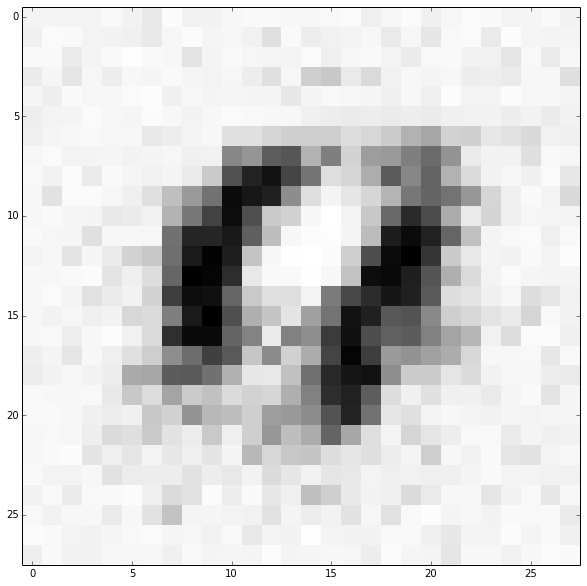

In [26]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(generate_images[index], cmap="Greys", interpolation="none")
plt.show()

Well ... It's OK.  It's very obviously not a digit, but it looks a bit like it *could* be a digit.  If you train this network on specific digits (1, 2,etc) I'm sure you will get much better performance.  Why not try it?